In [ ]:
%%capture
!uv pip install nnsight huggingface_hub[hf_xet] python-bidi arabic-reshaper

In [ ]:
import itertools
import os
import random
import re
from functools import lru_cache
from typing import List, Sequence, Tuple
import matplotlib
import matplotlib.pyplot as plt
import nnsight
import numpy as np
import torch
import tqdm
from nnsight import LanguageModel
import arabic_reshaper
from bidi.algorithm import get_display

matplotlib.style.use('default')

# utils

In [ ]:
@lru_cache(maxsize=None)
def get_activations_at_pos(prompts: Tuple[str, int]) -> List[torch.Tensor]:
    activations = [[] for _ in range(len(model.model.layers))]
    for prompt, position in tqdm.tqdm(prompts):
        with torch.no_grad():
            with model.trace(prompt):
                activations_for_prompt = nnsight.list().save()
                for layer_idx, layer in enumerate(model.model.layers):
                    activations_for_prompt.append(layer.mlp.down_proj.input[0][position].cpu().save())

            for layer_idx, layer_activations in enumerate(activations_for_prompt):
                activations[layer_idx].append(layer_activations)

        torch.cuda.empty_cache()

    return torch.stack([torch.stack(acts) for acts in activations], dim=1)

@lru_cache(maxsize=None)
def get_activations(prompts: Tuple[str]):
  return get_activations_at_pos((prompt, -1) for prompt in prompts)

In [ ]:
def plot_ranking(entity_name, scores, best_neurons):
    """
    Plot relative stability for top neurons, highlighting the best one.
    Updated aesthetics: centered title, colors, sans-serif font, fixed x-axis.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import arabic_reshaper
    from bidi.algorithm import get_display

    # Reset rcParams to default
    plt.rcParams.update(plt.rcParamsDefault)

    # Custom aesthetic settings
    plt.rcParams.update({
        "font.family": "sans-serif",
        "font.size": 10,
        "axes.spines.top": False,
        "axes.spines.right": False,
    })

    best_neurons = best_neurons[:6]
    labels = [f"L{n[0]}-{n[1]}" for n in best_neurons]
    raw_scores = np.array([scores[n[0], n[1]] for n in best_neurons])

    top_score = raw_scores.max()
    rel_scores = raw_scores / top_score

    top_idx = int(np.argmax(rel_scores))

    # High DPI for clarity
    fig, ax = plt.subplots(figsize=(5, 3.5), dpi=300)

    y_pos = np.arange(len(best_neurons))

    # Colorful but professional palette
    base_color = "#B0C4DE"  # Light Steel Blue
    highlight_color = "#2E598B" # Darker Blue for contrast

    colors = [highlight_color if i == top_idx else base_color
              for i in range(len(best_neurons))]

    bars = ax.barh(y_pos, rel_scores, color=colors, height=0.7, edgecolor="none")

    ax.invert_yaxis()

    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)

    for i, label in enumerate(ax.get_yticklabels()):
        if i == top_idx:
            label.set_fontweight("bold")
            label.set_color(highlight_color)
        else:
            label.set_color("#555555")

    # Strict x-axis limit as requested
    ax.set_xlim(0, 1.0)
    ax.set_xlabel("Stability Relative to Top Neuron", fontweight='medium', color="#333333")

    # Grid
    ax.xaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.7, color='gray')
    ax.set_axisbelow(True)

    for i, (bar, value) in enumerate(zip(bars, rel_scores)):
        # Check if text fits outside; if not (or if it's the top one), put inside
        is_top = (i == top_idx)
        if value > 0.85:
            # Place inside
            x_pos = bar.get_width() - 0.02
            ha = "right"
            color = "white" if is_top else "#333333"
        else:
            # Place outside
            x_pos = bar.get_width() + 0.02
            ha = "left"
            color = highlight_color if is_top else "#555555"

        ax.text(
            x_pos,
            bar.get_y() + bar.get_height() / 2,
            f"{value:.2f}",
            va="center",
            ha=ha,
            fontsize=9,
            color=color,
            fontweight="bold" if is_top else "normal",
        )

    reshaped_text = arabic_reshaper.reshape(entity_name)
    bidi_text = get_display(reshaped_text)

    # Centered Title
    ax.set_title(
        bidi_text,
        pad=12,
        fontweight="bold",
        fontsize=14,
        loc='center',
        color="#333333"
    )

    plt.tight_layout()
    plt.show()

In [ ]:
def compute_metrics(acts):
  return acts.mean(dim=0), acts.std(dim=0)

def compute_stability_score(acts):
  mean, std = compute_metrics(acts)
  return mean ** 2 / std

def z_score_normalize(acts, mean, std):
  return (acts - mean) / std

def generate_generic_prompts(prompts_file = 'generic_prompts.txt'):
  with open(prompts_file, 'r') as f:
    prompts = [line.strip() for line in f if line.strip()]
  return prompts

def rank_neurons(scores, k=-1):
  scores_ = scores.view(-1)
  return torch.stack(torch.unravel_index(scores_.topk(k=len(scores_)).indices,
                             scores.shape), dim=1)

# load data

In [ ]:
ATTRIBUTES = (
    "origin",
    "purpose",
    "definition",
    "function",
    "main goal",
    "age",
    "name",
    "founder",
    "owner",
    "value",
    "importance",
    "reputation",
    "impact",
    "influence",
    "location",
    "history",
    "status",
    "category",
    "type",
    "meaning",
    "significance",
    "role",
    "date of creation",
    "latest update",
    "duration",
    "size",
    "popularity",
    "main activity",
    "scope",
    "reach",
    "composition",
    "structure",
    "method",
    "strategy",
    "goal",
    "objective",
    "result",
    "effect",
    "outcome",
    "cause",
    "reason",
    "source",
    "destination",
    "trend",
    "main challenge",
    "opinion",
    "leading opinion",
    "common perception",
    "definition in law",
    "ethical standing",
    "main criticism",
    "key advantage",
    "key disadvantage",
    "limitation",
    "potential",
    "likelihood",
    "probability",
    "risk",
    "opportunity",
    "threat",
    "strength",
    "weakness",
    "main competitor",
    "main supporter",
    "main opponent",
    "relationship with others",
    "relevance",
    "timing",
    "frequency",
    "pattern",
    "cost",
    "budget",
    "revenue",
    "profit",
    "loss",
    "market share",
    "demographic",
    "representation",
    "policy",
    "regulation",
    "requirement",
    "recommendation",
    "limiting factor",
    "resource",
    "technology used",
    "process",
    "legal status",
    "acceptance",
    "approval",
    "recognition",
    "symbolism",
    "associations",
    "link to current events",
    "precedent",
    "measurement",
    "ranking",
    "priority",
    "main feature",
    "unique aspect",
    "distinguishing factor",
)
ENTITY_QUESTIONS = [f"The {p} of {{name}}" for p in ATTRIBUTES]

In [ ]:
GENERIC_PROMPTS = (
  "The Eiffel Tower is located in",
  "Photosynthesis occurs primarily in plant",
  "The Amazon River flows through",
  "The Earth revolves around the",
  "William Shakespeare was born in",
  "The Great Wall of China is",
  "The capital of France is",
  "The Pacific Ocean is the largest",
  "The Roman Empire fell in",
  "The Nobel Prize was established in",
  "The Pythagorean theorem relates to",
  "Alexander Graham Bell invented the",
  "The Renaissance began in the",
  "The human brain has",
  "The United Nations was founded in",
  "The Mona Lisa is an",
  "The solar system contains planets like",
  "The Eiffel Tower was completed in",
  "The Cold War lasted from",
  "The Titanic sank after hitting",
  "The capital of Japan is",
  "The Statue of Liberty was a gift from",
  "The first man on the moon was",
  "The Great Depression started in",
  "The Silk Road was a",
  "The history of the Internet began in",
  "The biosphere includes all",
  "The currency used in Japan is",
  "The human heart pumps blood through",
  "The Battle of Hastings occurred in",
  "The longest river in the world is",
  "The invention of the telephone revolutionized",
  "The Cold War intensified tensions between",
  "The element with atomic number is",
  "The human genome project mapped",
  "The ruling dynasty of China was",
  "The Great Depression was ignited by",
  "The Battle of Waterloo took place in",
  "The national flag of the United States features",
  "The concept of gravity was formulated by",
  "The primary colors are red, blue, and",
  "The London Underground is also called",
  "The discovery of penicillin by Alexander Fleming revolutionized",
  "The Sahara Desert is located in",
  "The Korean War started in",
  "The structure of DNA was discovered by",
  "The first artificial satellite was launched by",
  "The fall of the Roman Empire marked the beginning of",
  "The concept of democracy originated in",
  "The Cold War was characterized by",
  "The Great Fire of London occurred in",
  "The ancient Egyptians built the",
  "The scientific method involves observation and",
  "The Statue of Liberty was designed by",
  "The Battle of Gettysburg took place in",
  "The Japanese attack on Pearl Harbor occurred in",
  "The process of mitosis results in",
  "The Chinese invented paper during the",
  "The basic laws of physics include",
  "The Boston Tea Party was a protest against",
  "The invention of the wheel dates back to",
  "The solar eclipse occurs when the",
  "The first successful powered flight was made by",
  "The Zionist movement emerged in",
  "The Battle of Stalingrad was a turning point in",
  "The invention of the printing press by",
  "The Panama Canal connects the Atlantic and",
  "The reign of Queen Elizabeth II began in",
  "The Nobel Prizes are awarded annually in",
  "The painting \"Starry Night\" was created by",
  "The invention of the lightbulb is credited to",
  "The Treaty of Versailles ended the",
  "The World War II began in",
  "The discovery of America is credited to",
  "The laws of motion were formulated by",
  "The ancient Greek Olympics dates back to",
  "The timeline of the Roman Republic includes",
  "The process of photosynthesis converts sunlight into",
  "The first programmable computer was called",
  "The Union of Soviet Socialist Republics was established in",
  "The process of evolution was proposed by",
  "The Cold War involved the United States and",
  "The Nobel Prizes were founded by Alfred",
  "The discovery of gravity was made by",
  "The Amazon rainforest is home to",
  "The invention of the computer revolutionized",
  "The structure of the atom was described by",
  "The first World Cup was held in",
  "The Battle of Agincourt occurred in",
  "The discovery of electricity is credited to",
  "The construction of the Panama Canal was completed in",
  "The Declaration of Independence was signed in",
  "The International Space Station orbits the",
  "The human body contains approximately bones in",
  "The main components of the atmosphere include",
  "The first human to fly was named",
  "The history of cinema is marked by",
  "The theory of relativity was proposed by",
  "The founding of the United States took place in",
  "The phenomenon of black holes involves",
  "The Roman Colosseum was used for",
  "The discovery of penicillin revolutionized medicine by",
  "The Battle of Thermopylae was fought during",
  "The concept of zero originated in",
  "The Suez Canal connects the Red and",
  "The history of the Eiffel Tower involves",
  "The earliest known written language is",
  "The primary function of the big bang",
  "The invention of the printing press by",
  "The discovery of radioactive elements was credited to",
  "The Great Wall of China was built to",
  "The League of Nations was established after",
  "The first successful vaccine was developed for",
  "The industrial revolution began in the",
  "The history of aviation includes the Wright brothers",
  "The first human-made satellite was called",
  "The Spanish Armada was defeated in",
  "The process of fermentation is used in",
  "The history of the United Nations begins with",
  "The terms of the Treaty of Tordesillas divided",
  "The development of the Internet began in the",
  "The process of natural selection was described by",
  "The primary purpose of the United Nations is",
  "The ancient city of Rome was located in",
  "The first Olympic Games of modern era were held in",
  "The history of jazz music features prominent artists like",
  "The British Empire expanded through various",
  "The invention of the steam engine was significant for",
  "The origins of Buddhism trace back to",
  "The first human to reach the North Pole was",
  "The structure of the human skeleton includes",
  "The science of genetics studies inheritance of",
  "The first written law code in history was",
  "The invention of the electric motor is attributed to",
  "The history of the monarchy in England spans",
  "The Sumerians are known for their invention of",
  "The first successful powered flight was achieved by",
  "The discovery of the double helix structure of DNA was made by",
  "The early exploration of the Pacific was led by",
  "The concept of democracy was recorded in ancient",
  "The history of the Roman Republic ends with",
  "The development of the steam locomotive led to significant",
  "The ancient city of Carthage was destroyed in the",
  "The first female Nobel laureate was awarded for",
  "The fall of the Aztec Empire was led by",
  "The history of the Byzantine Empire includes the rule of",
  "The invention of the telescope revolutionized astronomy by",
  "The Sudanese civil war lasted from",
  "The origin of the universe is explained by the",
  "The first human to walk on Mars is",
  "The history of the French Revolution involves",
  "The primary function of the mitochondria in cells is",
  "The earliest known civilizations developed in the",
  "The structure of the United Nations headquarters is located in",
  "The history of the Cold War includes the Cuban missile crisis of",
  "The invention of the radio by Marconi marked the start of",
  "The ancient Maya civilization was located in",
  "The first successful cloning of a mammal was achieved with",
  "The history of the papal nuncio dates back to",
  "The process of renewable energy generation involves",
  "The early history of India is linked to the",
  "The first commercially successful computer was called",
  "The discovery of the Higgs boson particle was confirmed in",
  "The history of the Olympic movement was initiated in",
  "The development of the printing press facilitated the spread of",
  "The earliest known use of metal tools dates to",
  "The South African apartheid system was abolished in",
  "The history of the Civil Rights Movement involves leaders like",
  "The concept of the Big Bang theory was first proposed by",
  "The first successful test of a nuclear weapon was in",
  "The development of the shipping container transformed global",
  "The history of space exploration includes the Apollo",
  "The invention of the modern automobile is credited to",
  "The origin of the Internet is related to",
  "The discovery of the neutron was credited to",
  "The history of the human rights movement includes",
  "The discovery of the planet Neptune was made by",
  "The earliest known use of written language was in",
  "The development of quantum mechanics challenged classical",
  "The founding of the European Union began with the",
  "The history of printing in East Asia includes",
  "The earliest known cave paintings were created in",
  "The evolution of mammals occurred during the",
  "The invention of the calculator was based on",
  "The history of the Civil War in the United States began in",
  "The development of the steam-powered locomotive was crucial for",
  "The early history of Japan is marked by",
  "The discovery of the first antibiotic was credited to",
  "The origins of the Olympic Games trace back to",
  "The development of algebra originated in",
  "The history of the Cold War includes the Berlin Airlift of",
  "The invention of the GPS system revolutionized navigation by",
  "The earliest known city-state was in",
  "The history of the medieval period in Europe includes",
  "The development of the printing press enabled the spread of",
  "The history of the Reformation is associated with",
  "The first successful human lung transplant was performed in",
  "The ancient city of Athens was a major center of",
  "The discovery of the microchip in the 20th century paved the way for",
  "The history of the atomic bomb is linked to the Manhattan Project",
  "The earliest known written code was",
  "The development of the solar panel technology involved",
  "The first civil rights act was passed in",
  "The concept of the Internet of Things involves",
  "The discovery of the planet Pluto was announced in",
  "The history of the medieval Islamic Golden Age includes",
  "The invention of the movable type was a significant milestone for",
  "The earliest known agriculture practices date back to",
  "The development of the modern computer processor was achieved in",
  "The history of South American indigenous cultures includes",
  "The first successful heart transplant was performed in",
  "The origin of the waterfall's formation is related to",
  "The history of the African continent includes the rise of",
  "The development of renewable energy sources has increased in",
  "The earliest confirmed fossils of early humans are dated to",
  "The invention of the ballpoint pen by",
  "The history of the Ottoman Empire spans from",
  "The discovery of penicillin marked a turning point in",
  "The development of the internal combustion engine led to",
  "The history of the classical Greek philosophy features",
  "The first modern Olympic marathon was held in",
  "The discovery of the Van Allen radiation belts was made by",
  "The evolution of early mammals occurred during the",
  "The earliest evidence of complex societies was found in",
  "The history of the Mexican Revolution includes leaders like",
  "The development of the electric telegraph revolutionized",
  "The first successful vaccine for polio was developed in",
  "The discovery of the cosmic microwave background radiation supported",
  "The history of the civil rights movement includes important events such as",
  "The invention of the compact disc (CD) changed how people listened to music by",
  "The early history of the Silk Road involved trade routes connecting",
  "The development of the steam-powered ship opened new routes for",
  "The history of the Roman Catholic Church includes significant councils like",
  "The discovery of the ancient city of Pompeii was preserved by",
  "The evolution of early amphibians marks transition from",
  "The earliest known domesticated animals include",
  "The development of the modern banking system includes the emergence of",
  "The history of the Indian independence movement includes leaders like",
  "The first artificial satellite to orbit Mars was named",
  "The discovery of the comet Hale-Bopp was notable for",
  "The early history of Australia involves the arrival of the",
  "The development of the first jet aircraft was achieved in",
  "The history of the Enlightenment includes thinkers like",
  "The earliest known use of gunpowder was in",
  "The discovery of the asteroid belt occurred between the orbits of",
  "The development of the electric car has gained momentum since",
  "The history of the early space race includes the launch of",
  "The first climate change treaty was signed in",
  "The discovery of the first exoplanet was announced in",
  "The early history of the Vikings involved exploration of",
  "The development of the World Wide Web was initiated by",
  "The history of the science of meteorology involves the study of",
  "The discovery of the Double Bubble universe was a theoretical breakthrough in",
  "The earliest known use of agriculture in Eurasia was around",
  "The development of blockchain technology has impacted",
  "The history of the civil war in Syria spans from",
  "The first successful cloning of a sheep was achieved with",
  "The discovery of the first pulsar was significant for",
  "The early history of the Byzantine Empire was marked by",
  "The evolution of early primates is evident from fossils dating to",
  "The development of renewable energy policies varies across",
  "The history of the American Revolution includes the signing of",
  "The earliest known use of writing in Mesopotamia was in",
  "The discovery of the first black hole candidate was made in",
  "The development of the semiconductor revolutionized electronics by",
  "The history of the exploration of Africa includes",
  "The first successful AI program was called",
  "The discovery of fibrinogen advanced our understanding of",
  "The early history of the Korean Peninsula involved",
  "The development of electric power grids made possible by",
  "The history of the discovery of the New World involves",
  "The earliest known monotheistic religion was practiced in",
  "The invention of the modern refrigerator was by",
  "The history of the Sumerian civilization includes",
  "The first real-time operating system was developed in",
  "The discovery of the first windmill dates back to",
  "The development of synthetic polymers began in",
  "The history of the Renaissance in Italy is linked to",
  "The earliest known city in North America is",
  "The first successful women’s rights convention was held in",
  "The discovery of the ozone layer was made in the",
  "The development of the GPS system began during the",
  "The history of the Chinese dynasties includes the",
  "The first proof of the Higgs boson was announced in",
  "The early history of the African continent involves the development of",
  "The discovery of the first modern bacterium was credited to",
  "The development of the electric guitar revolutionized",
  "The history of the African-American civil rights movement involves",
  "The earliest known use of fire by humans dates to",
  "The discovery of the first exoplanet orbiting a sun-like star was in",
  "The development of gene editing technology CRISPR involves",
  "The history of the medieval European feudal system involves",
  "The first successful human kidney transplant was in",
  "The earliest evidence of hominid tool use was found in",
  "The discovery of the first asteroid impact crater was in",
  "The development of social media platforms like Facebook changed",
  "The history of the Chinese invention of paper involves",
  "The earliest known evidence of human art was in",
  "The invention of the modern bicycle was in",
  "The discovery of water on Mars was announced in",
  "The earliest recorded use of alphabetic",
  "The development of the internal combustion",
  "The history of the French Revolution includes",
  "The first successful human liver transplant",
  "The discovery of the Hubble Deep Field enabled",
  "The early history of the Inca civilization involves",
  "The development of electric lighting transformed",
  "The history of the Protestant Reformation involves",
  "The first recorded use of paper in",
  "The discovery of the Pacific Ocean's",
  "The development of the modern camera involved",
  "The history of the Vikings’ exploration includes",
  "The first use of gunpowder in",
  "The earliest forms of writing involved symbols in",
  "The development of modern antibiotics began with",
  "The history of the Renaissance art movement includes",
  "The earliest known use of currency was in",
  "The discovery of the microbe by",
  "The development of the World Wide Web was initiated by",
  "The history of the United States includes the",
  "The invention of the typewriter revolutionized",
  "The earliest known Chinese dynasties include",
  "The discovery of radioactivity led to",
  "The development of surgical anesthesia was achieved in",
  "The history of the scientific revolution includes",
  "The first successful human heart-lung machine was used in",
  "The earliest known examples of the wheel date to",
  "The development of the steam-powered locomotive began in",
  "The history of the European Age of Exploration includes",
  "The first modernist movement in art was in",
  "The discovery of the Comet Halley was in",
  "The early history of the Mongol Empire involved",
  "The development of the modern jet engine was achieved in",
  "The history of the early 20th-century feminism includes",
  "The earliest evidence of fire use by humans was in",
  "The discovery of the neutron was credited to",
  "The development of nuclear energy involved the",
  "The history of the ancient Indus Valley includes",
  "The first successful human lung transplant was in",
  "The earliest known use of eye makeup was in",
  "The discovery of the first exoplanet occurred in",
  "The development of the modern electronic computer was in",
  "The history of the British Empire’s expansion includes",
  "The first recorded solar eclipse observation was in",
  "The earliest evidence of domesticated plants was in",
  "The discovery of the asteroid Ida and its moon was in",
  "The development of the first AI chatbot began in",
  "The history of early Christianity includes",
  "The earliest known use of steel was in",
  "The discovery of cosmic rays was made by",
  "The development of space telescopes like Hubble enabled",
  "The history of the early Chinese Silk Road includes",
  "The first successful organ transplant procedure was in",
  "The earliest evidence of farming in Europe is",
  "The discovery of the Red Planet’s surface features was from",
  "The development of the steam engine revolutionized",
  "The history of the early African civilizations includes",
  "The first modern electronic digital computer was called",
  "The earliest known use of writing in Egypt was in",
  "The discovery of the first asteroid impact crater in",
  "The development of the modern semiconductor industry involved",
  "The history of the feminist movement in the early 1900s includes",
  "The first successful blood transfusion was in",
  "The earliest evidence of Homo erectus was found in",
  "The discovery of the structure of the atom was credited to",
  "The development of the internet’s early infrastructure was by",
  "The history of the Roman engineering marvels includes",
  "The first exclusive use of gunpowder in warfare was in",
  "The earliest known use of glass dates to",
  "The discovery of the first variable star was in",
  "The development of renewable energy sources varies across",
  "The history of the Islamic Golden Age involves advances in",
  "The first powered flight across the Atlantic was by",
  "The earliest known domesticated dogs were in",
  "The discovery of the first supernova remnant was in",
  "The development of modern vaccines began with",
  "The history of the early European Renaissance includes",
  "The first comprehensive map of the New World was created by",
  "The earliest use of metal tools was by",
  "The discovery of the ozone hole was in",
  "The development of the first pocket-sized computer was in",
  "The history of the early development of quantum theory includes researchers like",
  "The first space probe to Venus was launched in",
  "The earliest evidence of writing in the Americas was in",
  "The discovery of the planet Uranus was credited to",
  "The development of the modern rocket engine was achieved in",
  "The history of the Cold War arms race includes",
  "The first successful human kidney transplant was performed in",
  "The earliest evidence of language dating back to",
  "The discovery of the cosmic microwave background supported the",
  "The development of the electric motor greatly impacted",
  "The history of the early European colonization of Australia includes",
  "The first known use of paper in Europe was in",
  "The earliest evidence of Homo habilis was discovered in",
  "The discovery of the first black hole was in",
  "The development of genetic engineering involved the discovery of",
  "The history of the Silk Road trade routes spans from",
  "The first successful human organ transplantation was in",
  "The earliest evidence of pottery was in"
)

# main

In [ ]:
def get_top_neurons(entity_name: str):
  questions = tuple(q.format(name=entity_name) for q in ENTITY_QUESTIONS)

  baseline_acts = get_activations(GENERIC_PROMPTS) # per neuron
  acts = get_activations(questions)

  base_mean, base_std = compute_metrics(baseline_acts)
  normalized_acts = z_score_normalize(acts, base_mean, base_std)
  stability_scores = compute_stability_score(normalized_acts)
  rankings = rank_neurons(stability_scores)

  return rankings, stability_scores

In [ ]:
MODEL = "Qwen/Qwen2.5-7B" # @param
model = LanguageModel(MODEL, device_map='auto')

config.json:   0%|          | 0.00/686 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

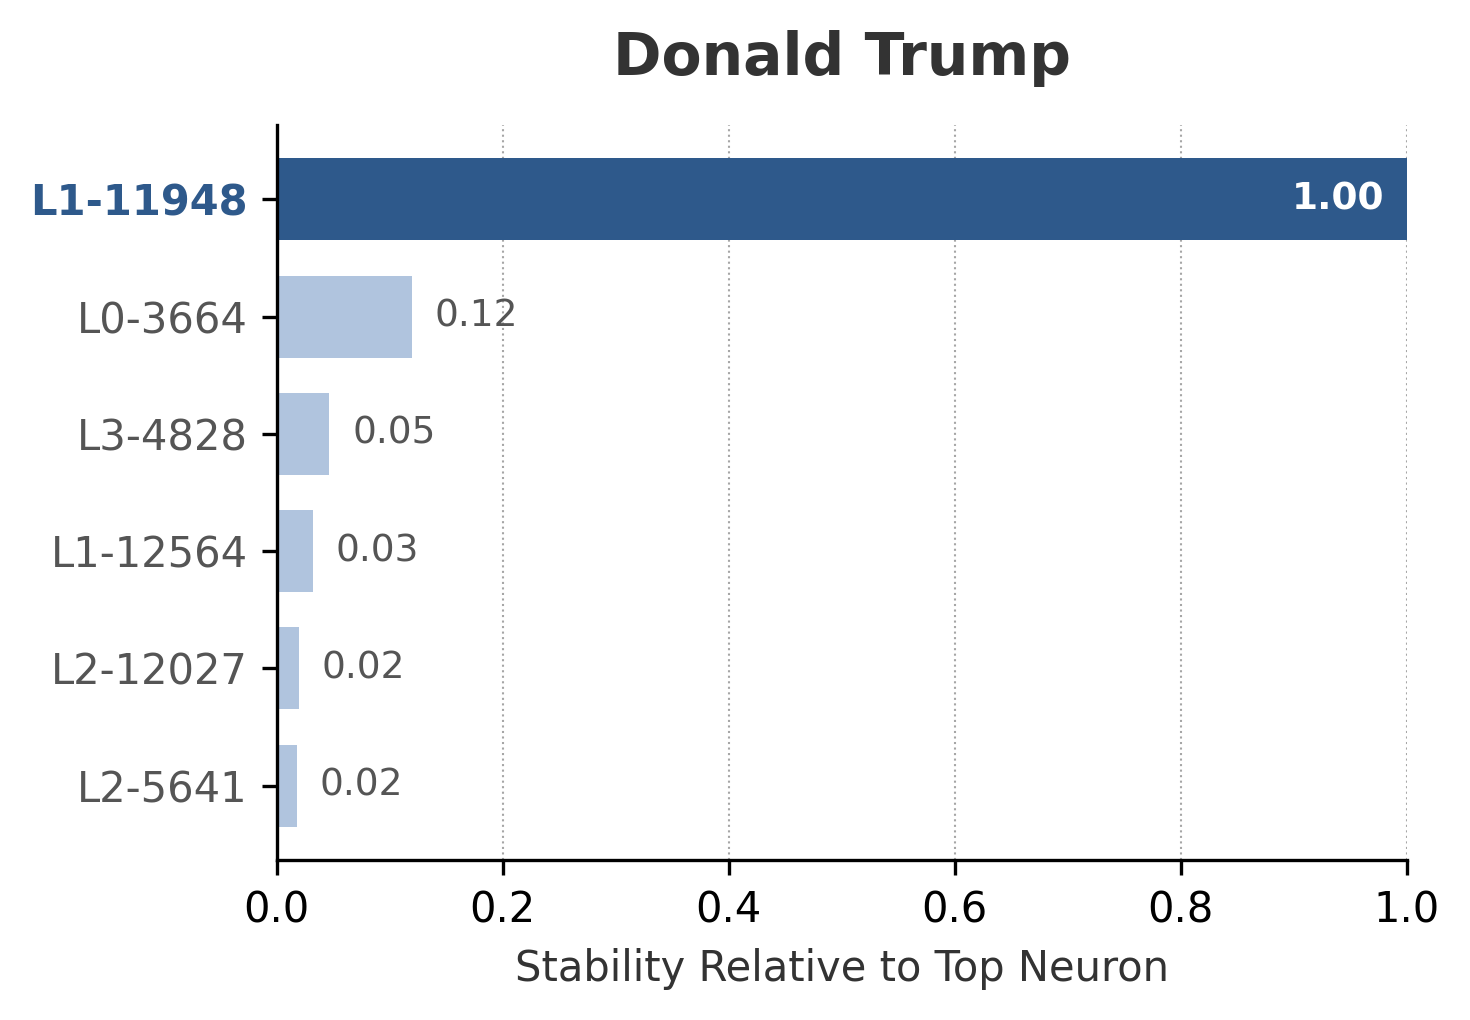

In [ ]:
for ent in ["Donald Trump"]:
  rankings, stability_scores = get_top_neurons(ent)
  plot_ranking(ent, stability_scores, rankings[:10])

0it [00:00, ?it/s]/usr/local/lib/python3.12/dist-packages/nnsight/__init__.py:82: UserWarning: builtins.list is deprecated as of v0.5.0 and will be removed in a future version.
Use the standard `list()` instead.
  warnings.warn(deprecation_message)
100it [00:07, 12.52it/s]


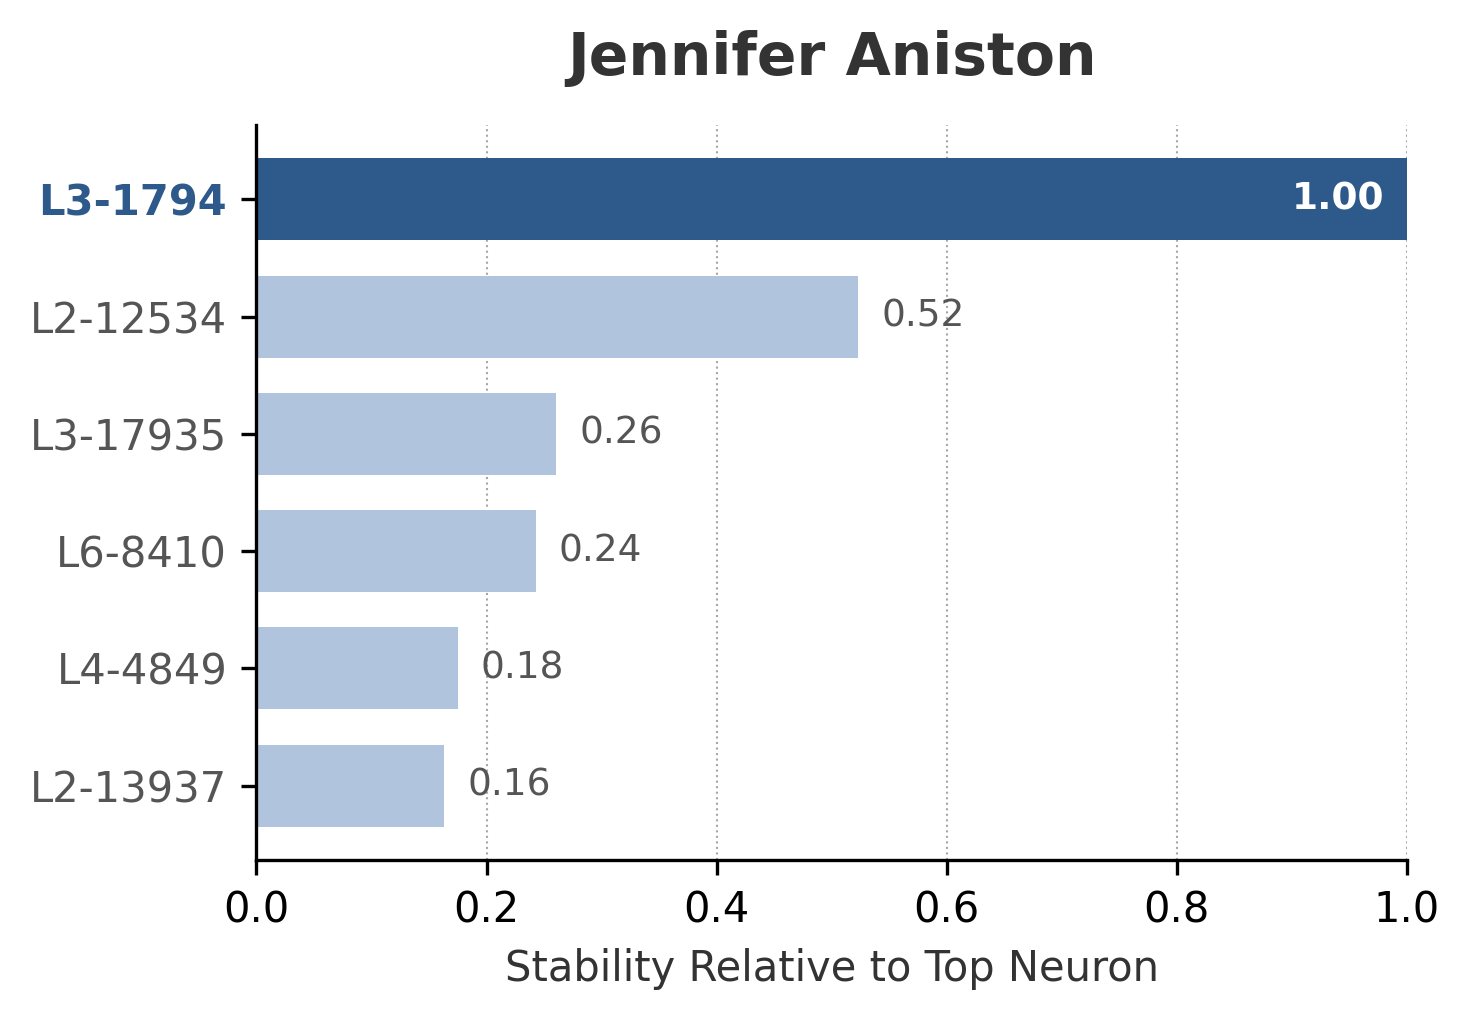

In [ ]:
for ent in ["Jennifer Aniston"]:
  rankings, stability_scores = get_top_neurons(ent)
  plot_ranking(ent, stability_scores, rankings[:10])

0it [00:00, ?it/s]/usr/local/lib/python3.12/dist-packages/nnsight/__init__.py:82: UserWarning: builtins.list is deprecated as of v0.5.0 and will be removed in a future version.
Use the standard `list()` instead.
  warnings.warn(deprecation_message)
100it [00:08, 12.47it/s]


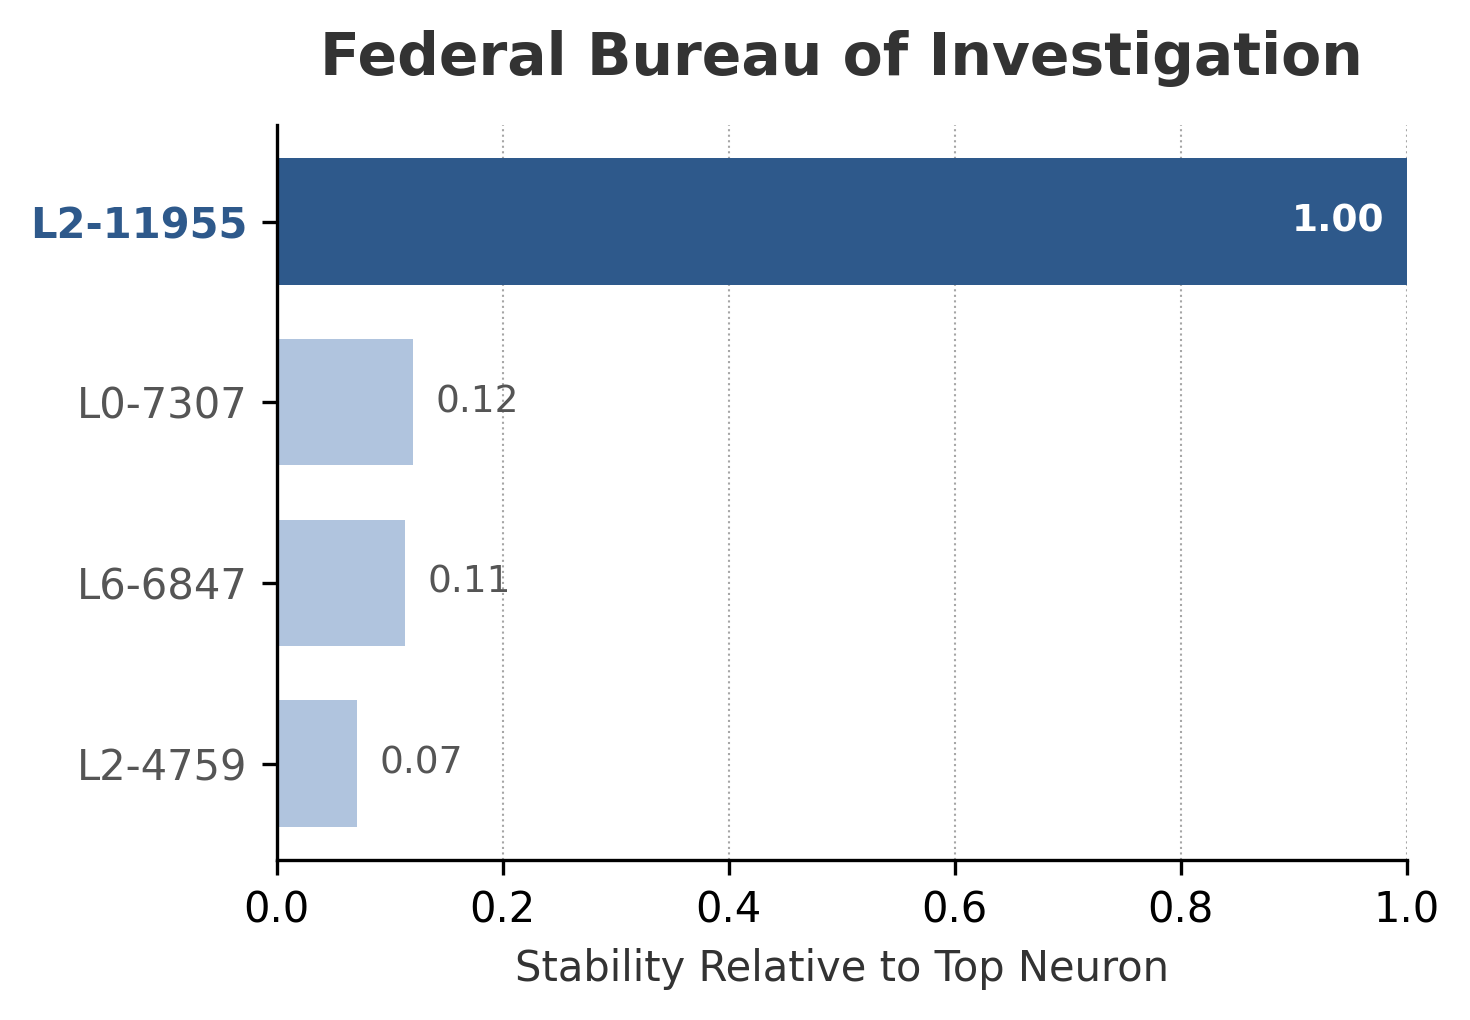

0it [00:00, ?it/s]/usr/local/lib/python3.12/dist-packages/nnsight/__init__.py:82: UserWarning: builtins.list is deprecated as of v0.5.0 and will be removed in a future version.
Use the standard `list()` instead.
  warnings.warn(deprecation_message)
100it [00:07, 13.59it/s]


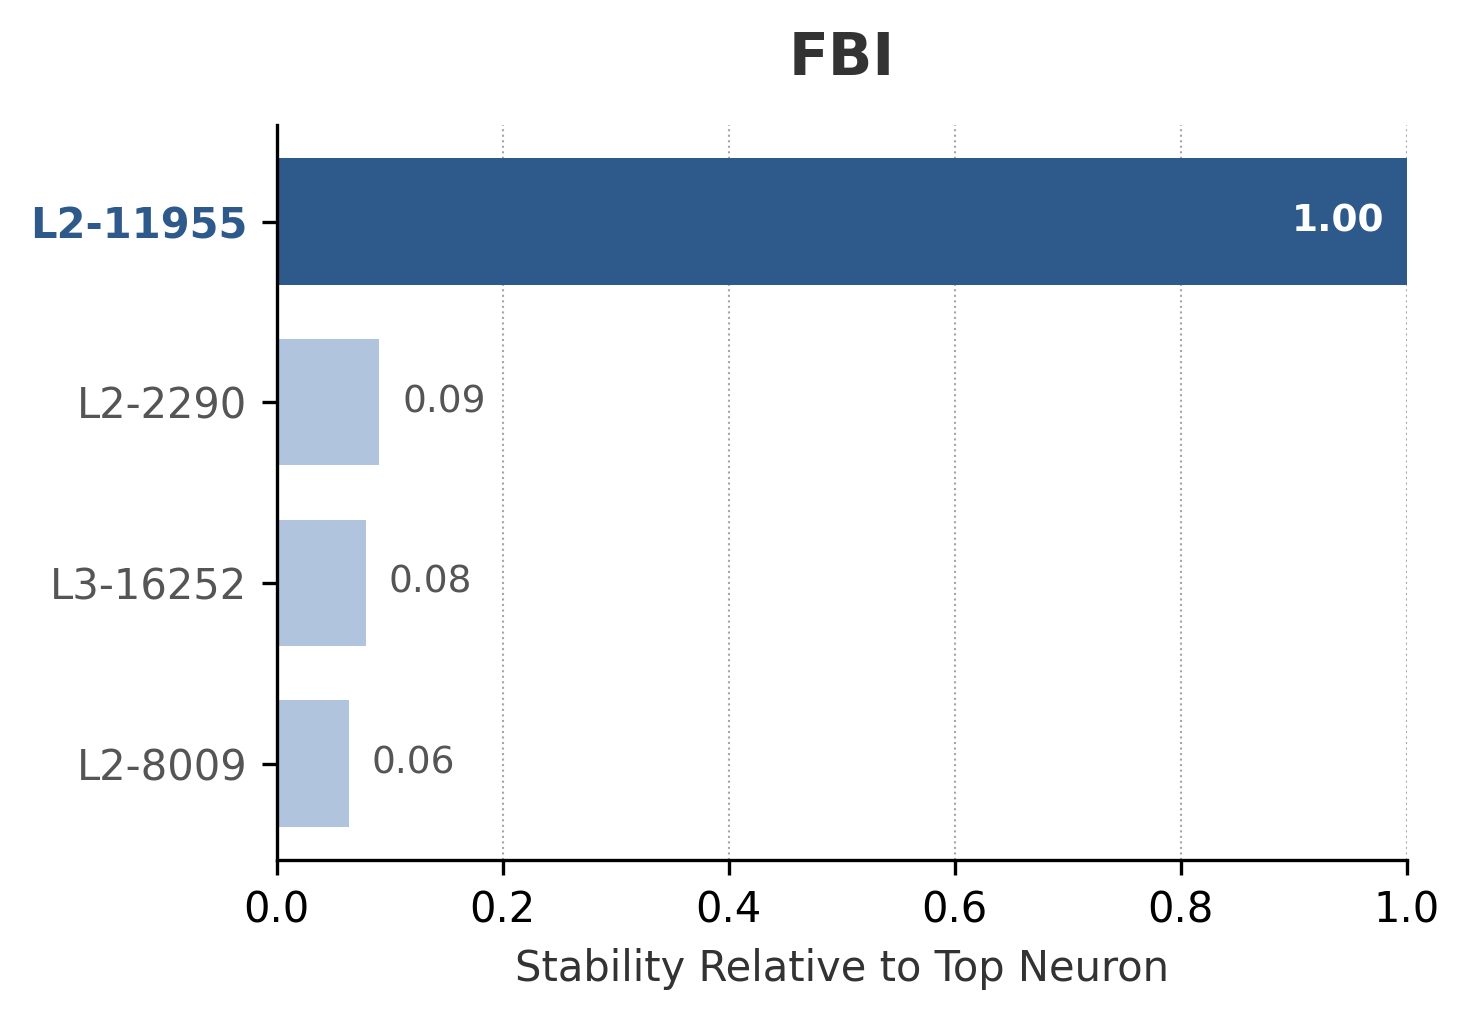

In [ ]:
for ent in ["Federal Bureau of Investigation", "FBI"]:
  rankings, stability_scores = get_top_neurons(ent)
  plot_ranking(ent, stability_scores, rankings[:4])

0it [00:00, ?it/s]/usr/local/lib/python3.12/dist-packages/nnsight/__init__.py:82: UserWarning: builtins.list is deprecated as of v0.5.0 and will be removed in a future version.
Use the standard `list()` instead.
  warnings.warn(deprecation_message)
100it [00:07, 13.48it/s]


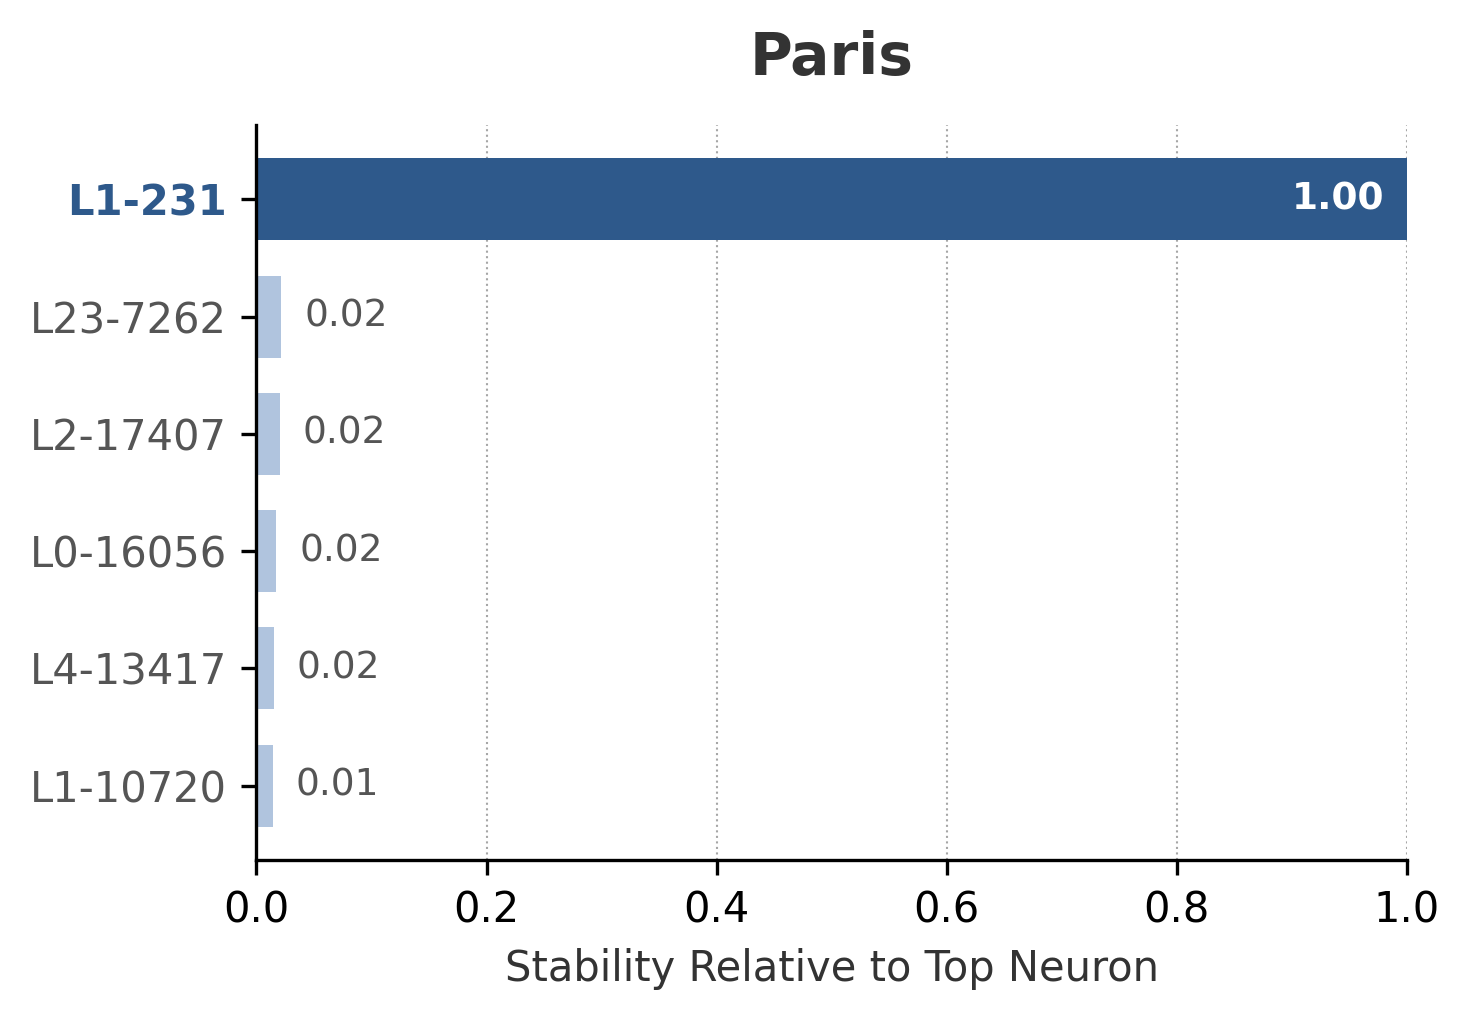

0it [00:00, ?it/s]/usr/local/lib/python3.12/dist-packages/nnsight/__init__.py:82: UserWarning: builtins.list is deprecated as of v0.5.0 and will be removed in a future version.
Use the standard `list()` instead.
  warnings.warn(deprecation_message)
100it [00:07, 12.95it/s]


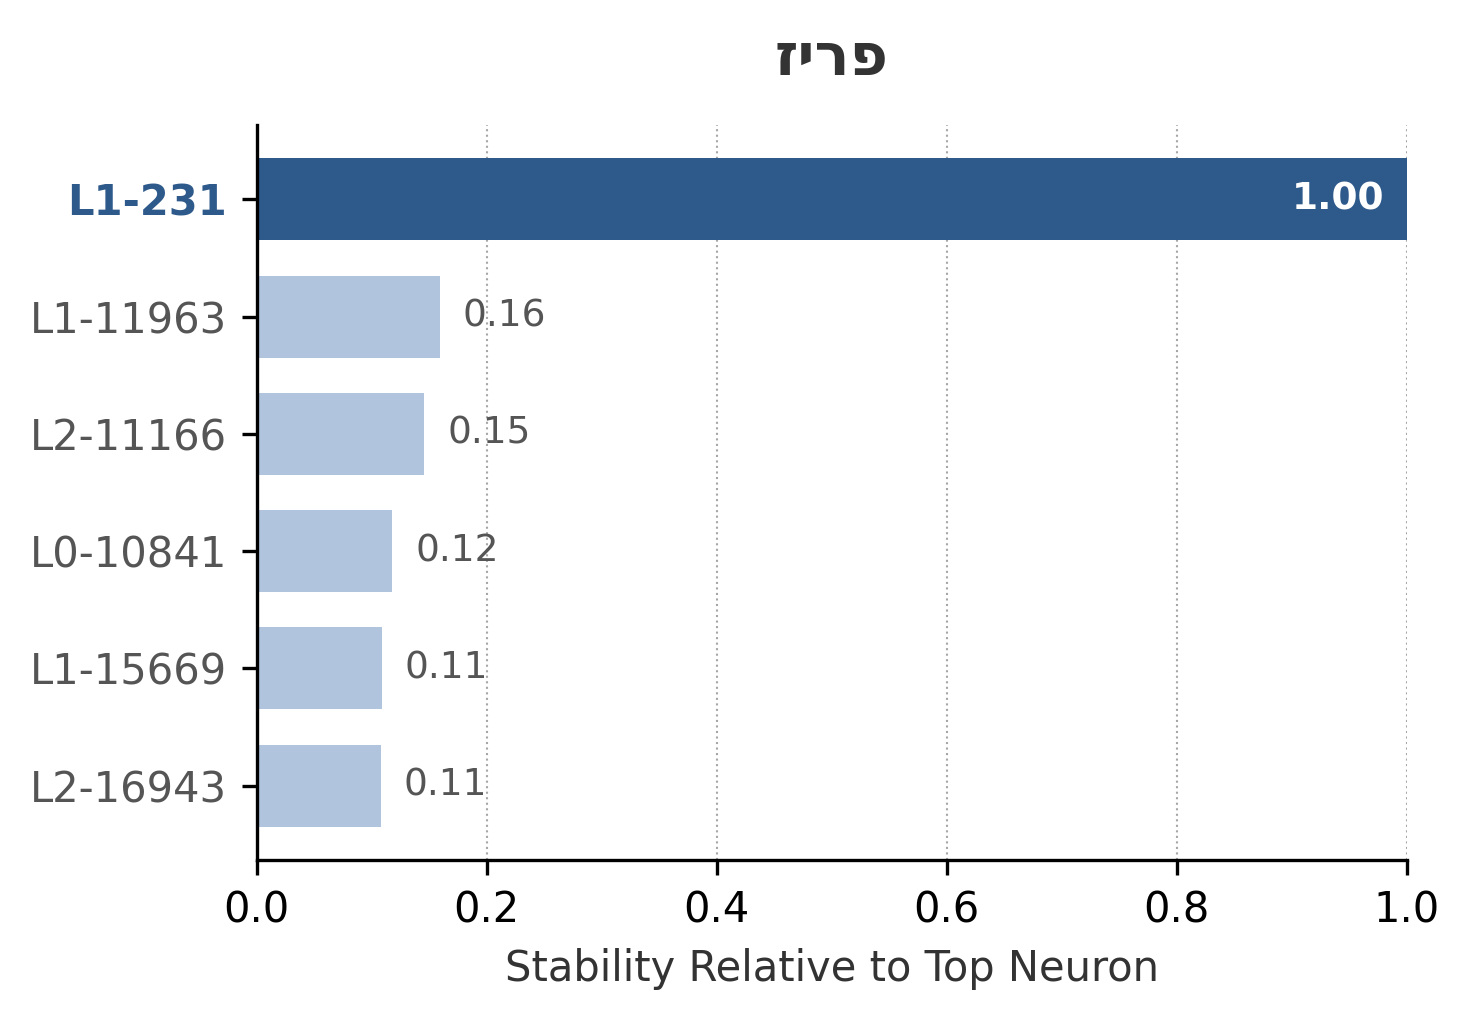

0it [00:00, ?it/s]/usr/local/lib/python3.12/dist-packages/nnsight/__init__.py:82: UserWarning: builtins.list is deprecated as of v0.5.0 and will be removed in a future version.
Use the standard `list()` instead.
  warnings.warn(deprecation_message)
100it [00:07, 12.83it/s]
/tmp/ipython-input-1583454148.py:103: UserWarning: Glyph 24052 (\N{CJK UNIFIED IDEOGRAPH-5DF4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1583454148.py:103: UserWarning: Glyph 40654 (\N{CJK UNIFIED IDEOGRAPH-9ECE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24052 (\N{CJK UNIFIED IDEOGRAPH-5DF4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 40654 (\N{CJK UNIFIED IDEOGRAPH-9ECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


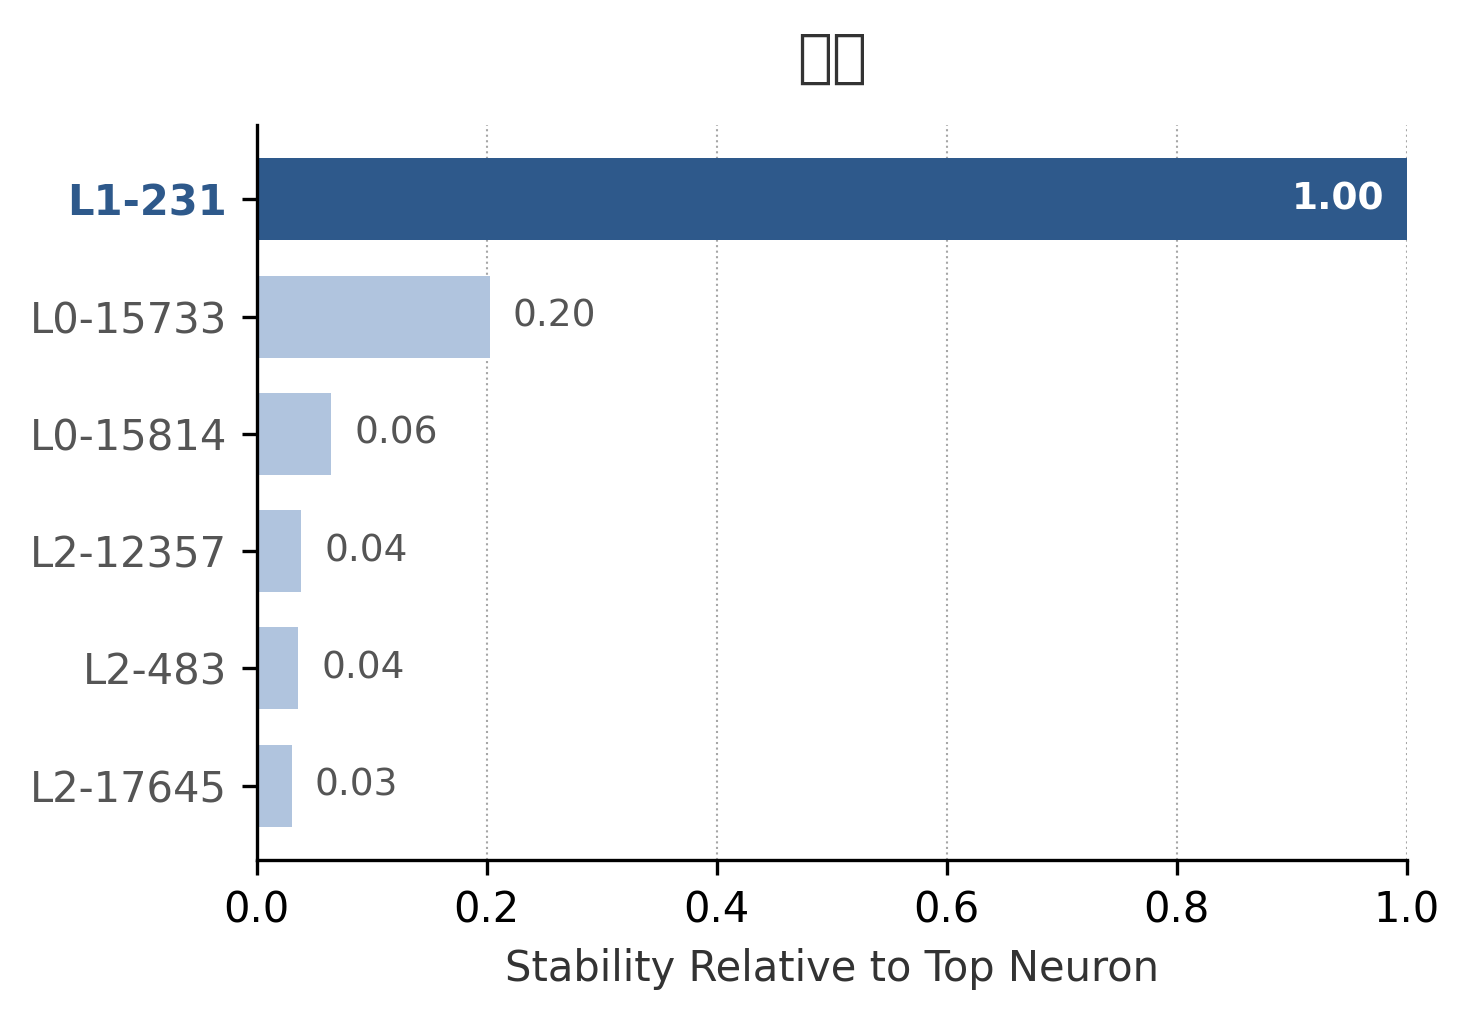

0it [00:00, ?it/s]/usr/local/lib/python3.12/dist-packages/nnsight/__init__.py:82: UserWarning: builtins.list is deprecated as of v0.5.0 and will be removed in a future version.
Use the standard `list()` instead.
  warnings.warn(deprecation_message)
100it [00:07, 12.82it/s]


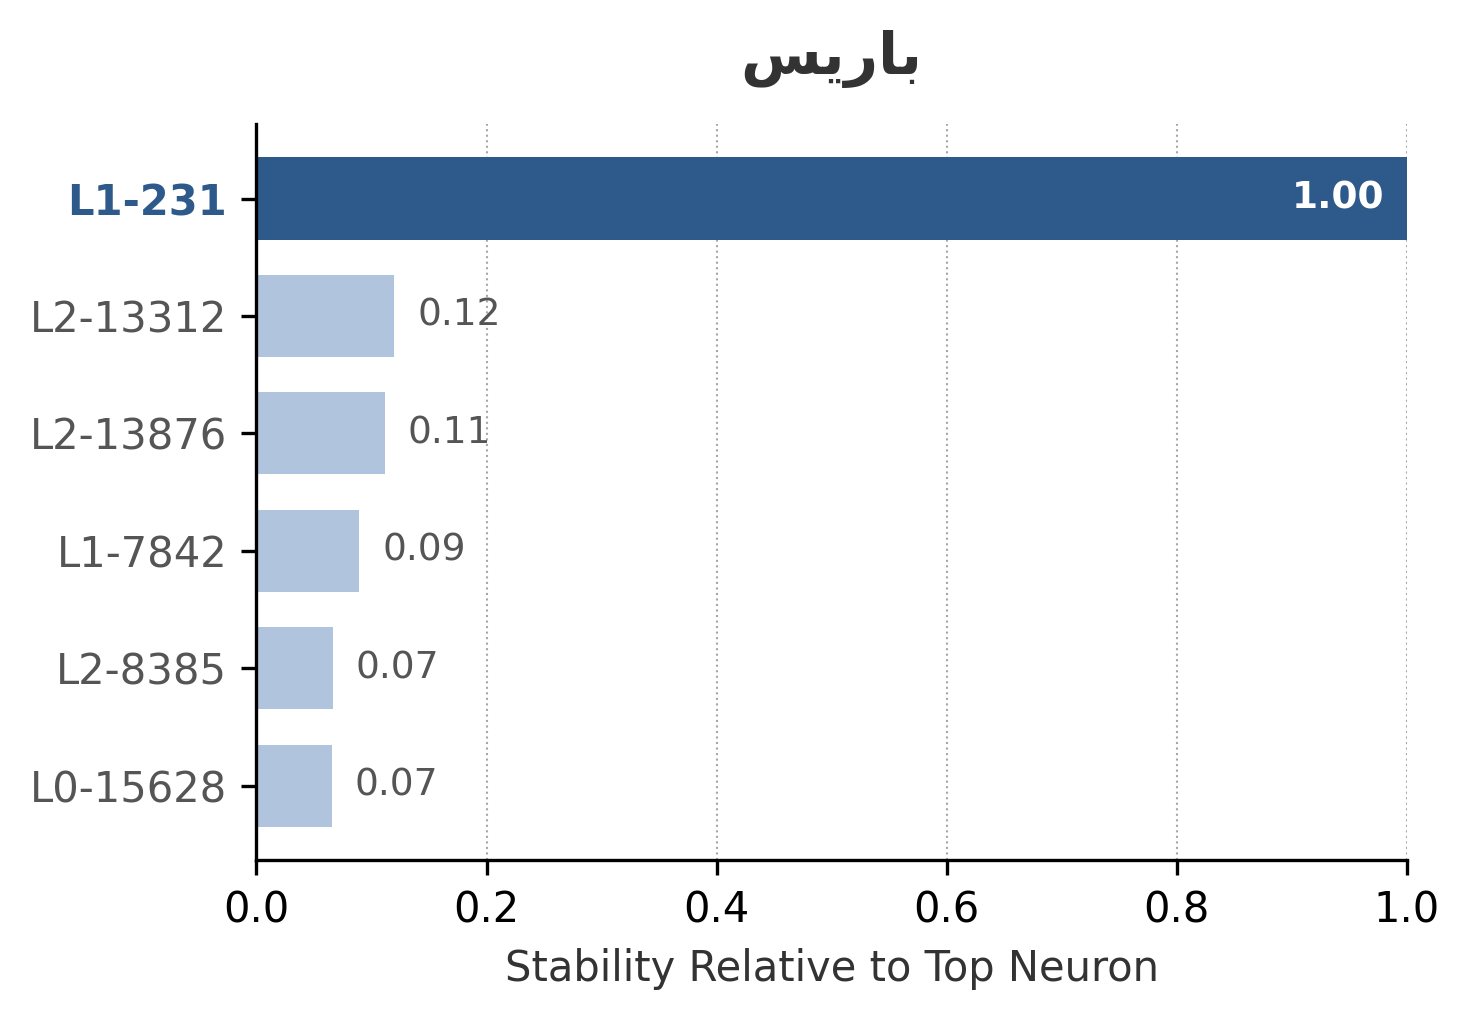

In [ ]:
for ent in ["Paris", "פריז", "巴黎", "باريس"]:
  rankings, stability_scores = get_top_neurons(ent)
  plot_ranking(ent, stability_scores, rankings[:10])

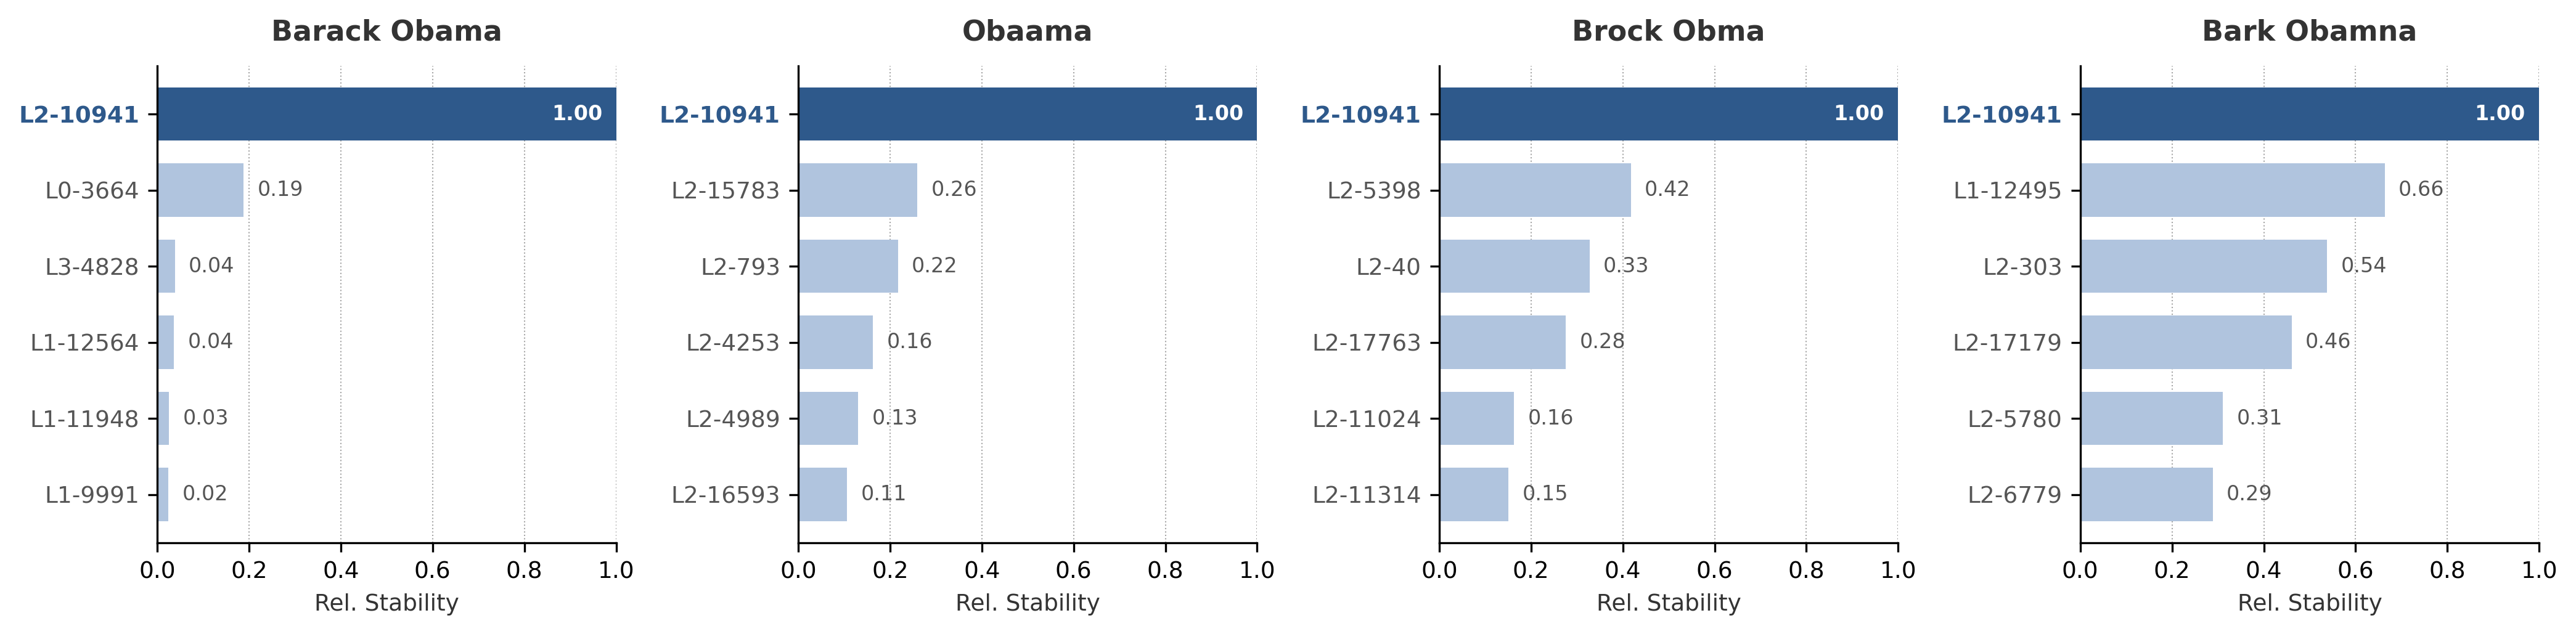

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import arabic_reshaper
from bidi.algorithm import get_display

entities = ["Barack Obama", "Obaama", "Brock Obma", "Bark Obamna"]

# Reset and set styling
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.size": 9,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# Create a single figure with 4 subplots
fig, axes = plt.subplots(1, 4, figsize=(14, 3.5), dpi=300)

for ax, ent in zip(axes, entities):
    # Get data
    rankings, stability_scores = get_top_neurons(ent)

    # Prepare data (Top 6)
    best_neurons = rankings[:6]
    labels = [f"L{n[0]}-{n[1]}" for n in best_neurons]
    raw_scores = np.array([stability_scores[n[0], n[1]] for n in best_neurons])

    top_score = raw_scores.max()
    rel_scores = raw_scores / top_score
    top_idx = int(np.argmax(rel_scores))

    y_pos = np.arange(len(best_neurons))

    # Colors
    base_color = "#B0C4DE"
    highlight_color = "#2E598B"
    colors = [highlight_color if i == top_idx else base_color for i in range(len(best_neurons))]

    # Plot
    bars = ax.barh(y_pos, rel_scores, color=colors, height=0.7, edgecolor="none")
    ax.invert_yaxis()
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.set_xlim(0, 1.0)

    # Styling
    for i, label in enumerate(ax.get_yticklabels()):
        label.set_color(highlight_color if i == top_idx else "#555555")
        if i == top_idx: label.set_fontweight("bold")

    ax.set_xlabel("Rel. Stability", fontweight='medium', color="#333333")
    ax.xaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.7, color='gray')
    ax.set_axisbelow(True)

    # Value labels
    for i, (bar, value) in enumerate(zip(bars, rel_scores)):
        is_top = (i == top_idx)
        if value > 0.85:
            x_pos = bar.get_width() - 0.03
            ha = "right"
            color = "white" if is_top else "#333333"
        else:
            x_pos = bar.get_width() + 0.03
            ha = "left"
            color = highlight_color if is_top else "#555555"

        ax.text(x_pos, bar.get_y() + bar.get_height()/2, f"{value:.2f}",
                va="center", ha=ha, fontsize=8, color=color,
                fontweight="bold" if is_top else "normal")

    # Title
    reshaped_text = arabic_reshaper.reshape(ent)
    bidi_text = get_display(reshaped_text)
    ax.set_title(bidi_text, pad=10, fontweight="bold", fontsize=11, color="#333333")

plt.tight_layout()
plt.show()